In [1]:
using PyPlot
include("../saltsolver.jl")
include("../passive.jl")

function mirrorflip(E)
    Eaug = [E[end]; E]
    flipdim(Eaug,1)[2:end]
end

function coefs(f, Es)
    dot(Es[1], f)/norm(Es[1])^2, dot(Es[2], f)/norm(Es[2])^2
end

/Users/davidliu/.julia/v0.4/Conda/deps/usr/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


coefs (generic function with 1 method)

In [3]:
n = 5
N = n * 6
L = 1.0
h = L/N
x = linspace(h, L, N)
F = 1 + 0.2 * cos(2π*n*x)
M = zeros(N, N)
laplacian!(J) = periodic!(J, h)
laplacian!(M)
Λ, X = eig(M)
reverse!(Λ)
X = X[:, reverse(1:N)]
ωs = √abs(Λ);

In [7]:
ieig = 4
ℓ = 2
E = X[:, ieig] + 1im * X[:, ieig+1]
ω = ωs[ieig]

12.474701449065549

In [8]:
ωa = 12.5
γ⟂ = 1.0
ɛ = (1 + im*0.3) * ones(N)
las = Laser(ɛ, F, ωa, γ⟂)
pmd = PassiveMode(copy(E), ω)
D = 0.3
passive_solve!(laplacian!, pmd, las, D, isprint=true)
imag(pmd.ω)

|f| = 36.72470297537255
|f| = 0.25630740033753546
|f| = 6.699571596994257e-5
|f| = 5.000023886594629e-12


-5.725641569714617e-5

In [42]:
Dt = passive_threshold!(laplacian!, pmd, las, (D, D*1.05))
ωt = real(pmd.ω)
pmdchiral = PassiveMode(project_chiral(pmd.E, n, ℓ), pmd.ω)
passive_solve!(laplacian!, pmdchiral, las, Dt, isprint=true)
println("instantly solved")
E₊ = copy(pmdchiral.E)
E₋ = mirrorflip(E₊);

|f| = 2.902714417126199e-6
|f| = 8.389326805443252e-13
instantly solved


In [45]:
H, Is, Js, Ks, GD = overlap_integrals((E₊, E₋), ωt, Dt, las, n, ℓ, L);
I, J, K = Is[1], Js[1], Ks[1]
ω1 = -imag(GD/I)/imag(H/I)
a = sqrt(real((ω1*H+GD)/I))

1.0179374537895458

In [43]:
d = 0.01
csq = d
D = Dt*(1+d)
md = Mode(copy(E₊), ωt, csq)
solve!(laplacian!, md, las, D);

In [74]:
npts = 5
ds = linspace(0, 0.0002, npts)
Λs = zeros(Complex{Float64}, length(ds), 4)
γpar = 5.0
for (i, d) in enumerate(ds)
    if i==1
        continue
    end
    D = Dt * (1+d)
    solve!(laplacian!, md, las, D)

    println("step ", i, " / ", npts)
    Λs[i, :] = smallest_stability_eigs(laplacian!, 
        sqrt(md.c²) * md.E, md.ω, D, γpar, las.ɛ)
end

step 2 / 5
step 3 / 5
step 4 / 5
step 5 / 5


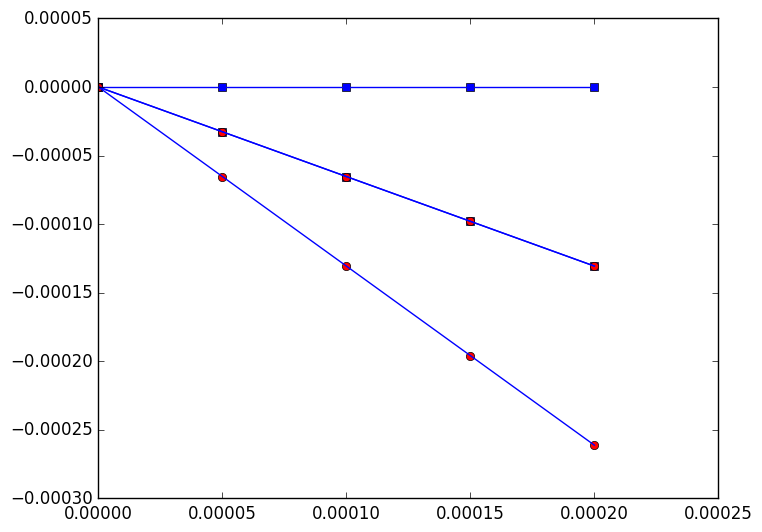

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x31b332d90>

In [75]:
plot(ds, real(Λs[:, 1]), "bs")
plot(ds, real(Λs[:, 2]), "bs")
plot(ds, real(Λs[:, 3]), "ro")
plot(ds, real(Λs[:, 4]), "ro")
th1 = zeros(ds)
th2 = 2*imag(I/H)*a^2 * ds
th3 = (imag(J/H) + sqrt(0.0im + abs(K/H)^2 - real(J/H)^2)) * a^2 * ds
th4 = (imag(J/H) - sqrt(0.0im + abs(K/H)^2 - real(J/H)^2)) * a^2 * ds
plot(ds, real(th1), "b-")
plot(ds, real(th2), "b-")
plot(ds, real(th3), "b-")
plot(ds, real(th4), "b-")

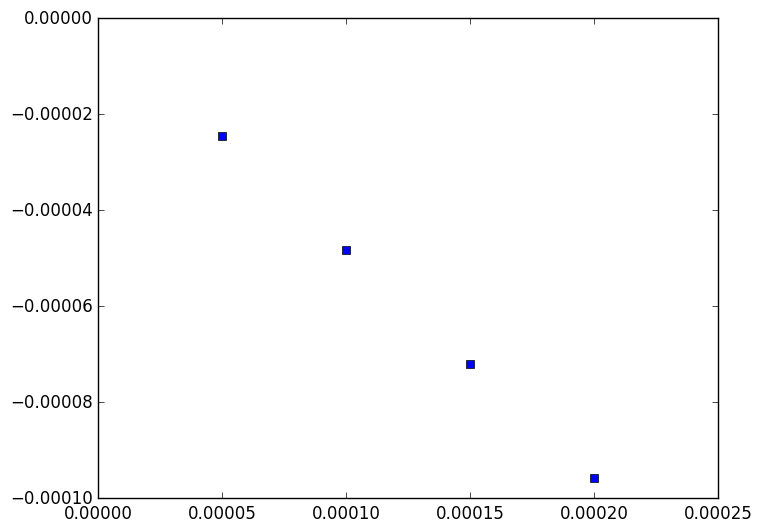

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x31d15cd10>

In [76]:
plot(ds, (real(Λs[:, 4]) - real(th2))./ds, "bs")
plot(0, 0)

In [77]:
d = 0.0002
D = Dt * (1+d)
npts = 10
γinvs = linspace(1/5, 1/0.01, npts)
Λγs = zeros(Complex{Float64}, length(γinvs), 4)

for (i, γinv) in enumerate(γinvs)
    γpar = 1/γinv
    solve!(laplacian!, md, las, D)

    println("step ", i, " / ", npts)
    Λγs[i, :] = smallest_stability_eigs(laplacian!, 
        sqrt(md.c²) * md.E, md.ω, D, γpar, las.ɛ)
end

step 1 / 10
step 2 / 10
step 3 / 10
step 4 / 10
step 5 / 10
step 6 / 10
step 7 / 10
step 8 / 10
step 9 / 10
step 10 / 10


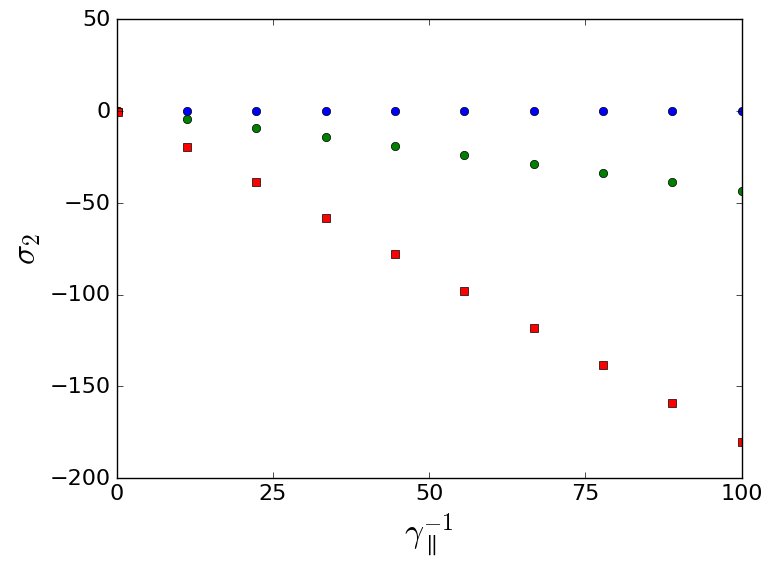

In [103]:
σth1 = 0
σth2 = 2*imag(I/H)*a^2 * d
σth3 = (imag(J/H) + sqrt(0.0im + abs(K/H)^2 - real(J/H)^2)) * a^2 * d
plot(γinvs, (real(Λγs[:, 1]) - 0)./d^2, "o")
plot(γinvs, (real(Λγs[:, 2]) - real(σth3))./d^2, "o")
plot(γinvs, (real(Λγs[:, 4]) - real(σth2))./d^2, "s")
#ylim([-0.05, 0])
rc("font", size=16)
xticks(linspace(0, 100, 5))
#yticks(linspace(-0.04, 0.02, 4))
xlabel(L"\gamma_\parallel^{-1}", fontsize=24)
ylabel(L"\sigma_2", fontsize=24)
tight_layout()
savefig("gampar.pdf")

In [83]:
γinvs

linspace(0.2,100.0,10)